# Detecting Malaria cells

## 1. Importing libraries

In [1]:
#Importing Necessary Libraries.
from PIL import Image
import numpy as np
import os
import cv2
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


In [25]:
data=[]
labels=[]
Parasitized=os.listdir("C:/Users/Anarchy/Documents/Data_Science/Malaria/Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("C:/Users/Anarchy/Documents/Data_Science/Malaria/Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Uninfected=os.listdir("C:/Users/Anarchy/Documents/Data_Science/Malaria/Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("C:/Users/Anarchy/Documents/Data_Science/Malaria/Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

In [26]:
Cells=np.array(data)
labels=np.array(labels)

In [27]:
np.save("Cells",Cells)
np.save("labels",labels)

In [28]:
Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

In [29]:
s=np.arange(Cells.shape[0])
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [30]:
num_classes=len(np.unique(labels))
len_data=len(Cells)

In [31]:
(x_train,x_test)=Cells[(int)(0.1*len_data):],Cells[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [32]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

In [33]:
#Doing One hot encoding as classifier has multiple classes
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [34]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

In [35]:
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
#Fit the model with min batch size as 50[can tune batch size to some factor of 2^power ] 
model.fit(x_train,y_train,batch_size=50,epochs=20,verbose=1)

Epoch 1/20
497/497 [==============================] - 7s 6ms/step - loss: 0.3378 - accuracy: 0.8473
Epoch 2/20
497/497 [==============================] - 3s 6ms/step - loss: 0.1606 - accuracy: 0.9498
Epoch 3/20
497/497 [==============================] - 3s 6ms/step - loss: 0.1406 - accuracy: 0.9552
Epoch 4/20
497/497 [==============================] - 3s 6ms/step - loss: 0.1306 - accuracy: 0.9572
Epoch 5/20
497/497 [==============================] - 3s 6ms/step - loss: 0.1225 - accuracy: 0.9592
Epoch 6/20
497/497 [==============================] - 3s 6ms/step - loss: 0.1156 - accuracy: 0.9618
Epoch 7/20
497/497 [==============================] - 3s 6ms/step - loss: 0.1069 - accuracy: 0.9630
Epoch 8/20
497/497 [==============================] - 3s 7ms/step - loss: 0.1021 - accuracy: 0.9643
Epoch 9/20
497/497 [==============================] - 3s 7ms/step - loss: 0.0952 - accuracy: 0.9654
Epoch 10/20
497/497 [==============================] - 3s 7ms/step - loss: 0.0891 - accuracy: 0.9677

In [37]:
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

87/87 [==============================] - 1s 4ms/step - loss: 0.1617 - accuracy: 0.9623

 Test_Accuracy:- 0.9622504711151123


87/87 [==============================] - 0s 4ms/step


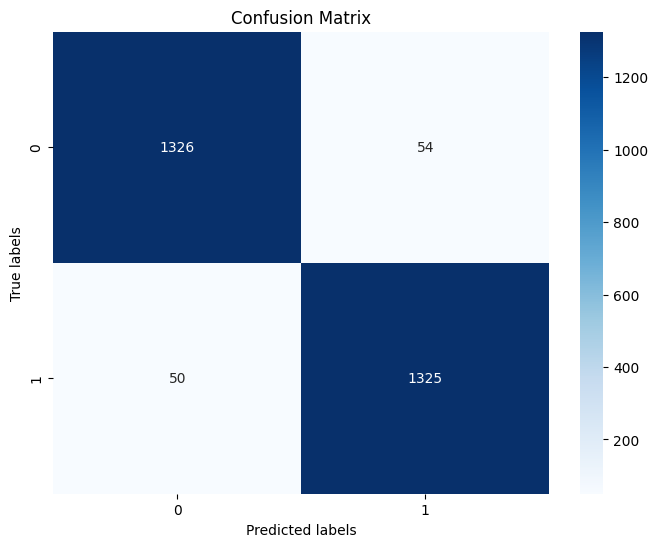

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Confusion Matrix and Heatmap
y_pred = model.predict(x_test)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [40]:
# 2. Classification Report
class_report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1380
           1       0.96      0.96      0.96      1375

    accuracy                           0.96      2755
   macro avg       0.96      0.96      0.96      2755
weighted avg       0.96      0.96      0.96      2755



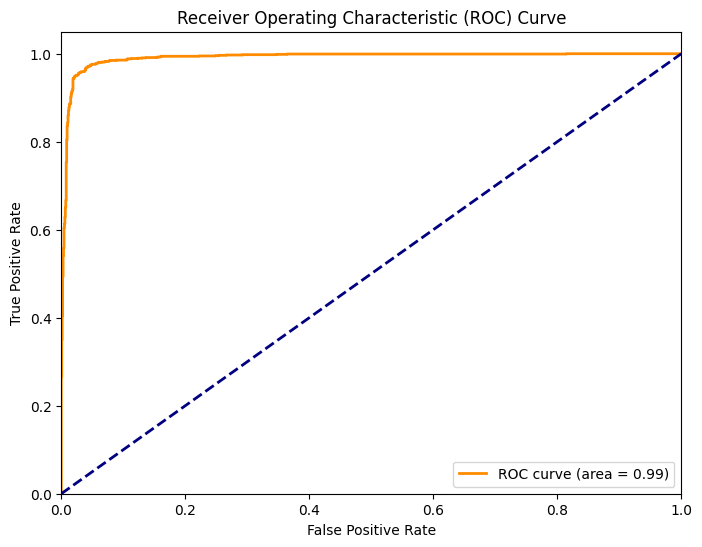

In [41]:
# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()